In [2]:
import random
import numpy as np
import os
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.sparse.csgraph import laplacian
from scipy.sparse.linalg import eigsh
from scipy.stats import spearmanr, kendalltau, pearsonr
from tqdm import *
from sklearn.manifold import SpectralEmbedding

In [ ]:
def heat_plot(data):

    plt.figure(figsize=(4, 4))
    plt.imshow(data,interpolation='nearest')
    plt.colorbar()

    # 添加标题和标签
    plt.title('')
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_xticks([]) 
    plt.gca().set_yticks([])  
    plt.axis('off')
    # plt.show()


def get_PEMS_adj(num_sensors, dist_df):
  dist = pd.read_csv(dist_df)
  dist_mx = np.zeros((num_sensors, num_sensors), dtype=np.float32)
  dist_mx[:] = np.inf
  dist_num = len(dist)
  for i in range(num_sensors):
    dist_mx[i, i] = 0
  for i in range(dist_num):
    from_d = dist.iloc[i, 0]
    to_d = dist.iloc[i, 1]
    cost_d = dist.iloc[i, 2]
    dist_mx[from_d, to_d] = cost_d
  distances = dist_mx[~np.isinf(dist_mx)].flatten()
  std = distances.std()
  factor = std
  adj_mx = np.exp(-np.square(dist_mx / factor))
  new_mx = 1 - adj_mx

  arr_without_one = np.where(adj_mx == 1, -np.inf, adj_mx)

  return adj_mx, dist_mx, new_mx


def read_txt_file(filename):
  with open(filename, 'r') as f:
    lines = f.readlines()
  cleaned_lines = [line.strip() for line in lines]
  array_data = np.array(cleaned_lines, dtype=float)  # 修改dtype根据需要
  return list(array_data)


def get_PEMS03_adj(num_sensors, dist_df, txt_path):
  id_order = read_txt_file(txt_path)
  dist = pd.read_csv(dist_df)
  dist_mx = np.zeros((num_sensors, num_sensors), dtype=np.float32)
  dist_mx[:] = np.inf
  dist_num = len(dist)
  for i in range(num_sensors):
    dist_mx[i, i] = 0
  for i in range(dist_num):
    from_d = id_order.index(dist.iloc[i, 0])
    to_d = id_order.index(dist.iloc[i, 1])
    cost_d = dist.iloc[i, 2]
    dist_mx[from_d, to_d] = cost_d
  distances = dist_mx[~np.isinf(dist_mx)].flatten()
  std = distances.std()
  factor = std
  adj_mx = np.exp(-np.square(dist_mx / factor))
  new_mx = 1 - adj_mx

  return adj_mx, dist_mx, new_mx

In [ ]:
def laplacian_embedding(x):
  embedder = SpectralEmbedding(n_components=1)
  x_transformed = embedder.fit_transform(x)
  return x_transformed[:, 0]


def corr_matrix(data, corr_type):
  mat = np.copy(data)
  count = 0

  if corr_type == 'Pearson':
    correlation_matrix = np.ones((mat.shape[1], mat.shape[1]))
    for i in range(mat.shape[1]):
      for j in range(i + 1, mat.shape[1]):
        if np.all(mat[:, i] == mat[0, i]) or np.all(mat[:, j] == mat[0, j]):
          correlation_matrix[i][j] = 0
          correlation_matrix[j][i] = 0
        else:
          correlation_matrix[i][j], _ = pearsonr(mat[:, i], mat[:, j])
          correlation_matrix[j][i] = correlation_matrix[i][j]
        if _ > 0.01:
          count += 1
  elif corr_type == 'Spearmanr':
    correlation_matrix, _ = spearmanr(mat)
    for i in range(mat.shape[1]):
      for j in range(i + 1, mat.shape[1]):
        if _[i, j] > 0.01:
          count += 1
  elif corr_type == 'Kendalltau':
    correlation_matrix = np.ones((mat.shape[1], mat.shape[1]))
    for i in range(mat.shape[1]):
      for j in range(i + 1, mat.shape[1]):
        correlation_matrix[i][j], _ = kendalltau(mat[:, i], mat[:, j])
        correlation_matrix[j][i] = correlation_matrix[i][j]
        if _ > 0.01:
          count += 1
  else:
    print("no such type corr_matrix")
    return 0

  return correlation_matrix, count


def rank_array(arr):
  sorted_indices = sorted(range(len(arr)), key=lambda k: arr[k])
  ranks = [0] * len(arr)
  for i, idx in enumerate(sorted_indices):
    ranks[idx] = i
  return ranks


def compute(data):
  mx = np.zeros((data.shape[0],data.shape[0]))
  for i in range(data.shape[0]):
    for j in range(data.shape[0], i):
      distance = np.linalg.norm(data[i,:] - data[j,:], ord=2)
      mx[i, j] = distance
      mx[j, i] = distance
  return mx


def dsc(data, s_type):
  if s_type=='Pearson':
    mx, _ = corr_matrix(data, 'Pearson')

  return mx

In [ ]:
def reorder_data(data_path, factor_k=1.0, active_num=1.0):

  data = pd.read_csv(data_path).iloc[:, 1:].values

  data = data[:int(data.shape[0]*0.7),:]
  corr_mx, count = corr_matrix(data, 'Pearson')
  adj_mx = abs(corr_mx)

  s_mx0 = np.copy((1/(1+np.exp(active_num*(-adj_mx+1/2)))-1/(1+np.exp(active_num/2)))/(1/(1+np.exp(-active_num/2))-1/(1+np.exp(active_num/2))))
  s_mx0 = s_mx0 ** factor_k
  heat_plot(s_mx0)
  s_order = laplacian_embedding(s_mx0)
  s_ranks = rank_array(s_order)
  s_list0 = list(s_ranks)

  dist_new = np.copy(s_mx0)
  for i in range(data.shape[1]):
    for j in range(data.shape[1]):
      dist_new[i,j] = s_mx0[s_list0.index(i),s_list0.index(j)]

  heat_plot(dist_new)

  return s_list0, s_mx0, dist_new

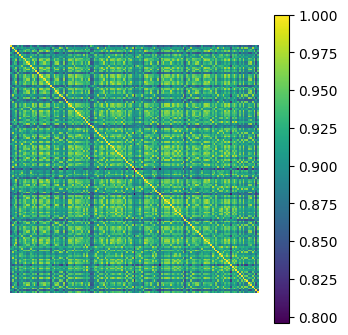

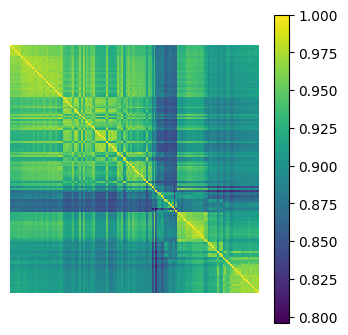

In [ ]:
root_path = '/home/yzh/Data/traffic'
data_path = 'traffic.csv'

data_file = os.path.join(root_path, data_path)

d_list,s_mx0,dist_new = reorder_data(data_file)

In [ ]:
def reorder_d(data_path, data_loc=None, txt_path=None, factor_k=1.0, active_num=1.0):
  
    data = np.load(data_path, allow_pickle=True)
    data = data['data'][:, :, 0]

    if txt_path is not None:
        d_mx, dist_mx, new_mx = get_PEMS03_adj(data.shape[1], data_loc, txt_path)
    else:
        d_mx, dist_mx, new_mx = get_PEMS_adj(data.shape[1], data_loc)
  
    heat_plot(dist_mx)
    d_mx0 = np.copy((1/(1+np.exp(active_num*(-d_mx+1/2)))-1/(1+np.exp(active_num/2)))/(1/(1+np.exp(-active_num/2))-1/(1+np.exp(active_num/2))))
    d_mx0 = d_mx0 ** factor_k

    # 映射向量值
    d_order = laplacian_embedding(d_mx0)
    # 重排列顺序
    d_ranks = rank_array(d_order)
    d_list = list(d_ranks)

    dist_new = np.copy(d_mx)
    for i in range(data.shape[1]):
        for j in range(data.shape[1]):
            dist_new[i,j] = dist_mx[d_list.index(i),d_list.index(j)]

    heat_plot(dist_new)

    return d_list, dist_mx, dist_new

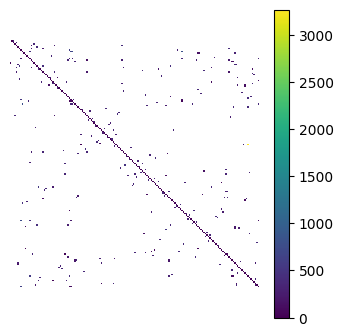

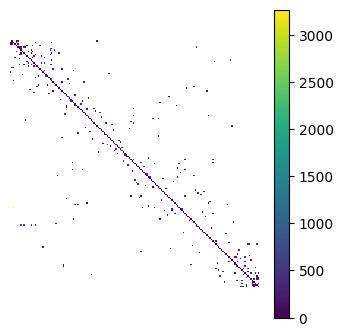

In [ ]:
root_path = '/home/yzh/Data/PEMS/PEMS08'
data_path = 'PEMS08.npz'
data_file = os.path.join(root_path, data_path)
dl = '/home/yzh/Data/PEMS/PEMS08/PEMS08.csv'
tp=None
#tp = '/home/yzh/Data/PEMS/PEMS03/PEMS03.txt'
k=1.0
q=1.0

d_list, dist_mx, dist_new = reorder_d(data_file,data_loc=dl,txt_path=tp,factor_k=k,active_num=q)